<h1 align=center><font size = 5>Pet Grooming</font></h1>

## 1.0 Initialization

In [1]:
print('Installing project imports and libraries start....')
print('Installing Geopy....')
!pip install geopy  # install geopy library
print('Installing Geopy.... done')

print('Installing Folioum....')
!conda install -c conda-forge folium=0.5.0 --yes    # install folium library

print('Installing Folium.... done')

print('Importing Basic Math libraries....')
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import numpy as np 
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json  #library to process JSON files 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import requests # library to handle http requests
from sklearn.cluster import KMeans # For ML modelling

# for Optimal K mapping
from sklearn import metrics 
from scipy.spatial.distance import cdist
import folium # map rendering library
print('Importing Math libraries.... done')
print('Installing project imports and libraries start....done')

Installing project imports and libraries start....
Installing Geopy....
     |████████████████████████████████| 112kB 6.4MB/s eta 0:00:01
Installing Geopy.... done
Installing Folioum....
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    attrs-20.3.0               |     pyhd3deb0d_0          41 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7

## 2.0 Additonal Settings

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

##  3.0 Data Peperation

In [13]:
# Read the township details from  the csv file in to the panda data frame
township_df = pd.read_csv('wake-townships.csv')

In [14]:
# display the first 20 rows of the twonship data frame
township_df.head(20)

,Town,Latitude,Longitude,Population
0,Bartons Creek,35.950664,-78.645547,22055
1,Buckhorn,35.655147,-78.940138,3251
2,Cary,35.791357,-78.781622,74074
3,Cedar Fork,35.861111,-78.814722,40841
4,Holly Springs,35.636988,-78.860912,33071
5,House Creek,35.866778,-78.668240,57439
6,Leesville,35.914125,-78.713608,41850
7,Little River,35.843485,-78.315941,12528
8,Marks Creek,35.809344,-78.406973,21932
9,Meredith,35.811332,-78.707938,13926


<AxesSubplot:xlabel='Town'>

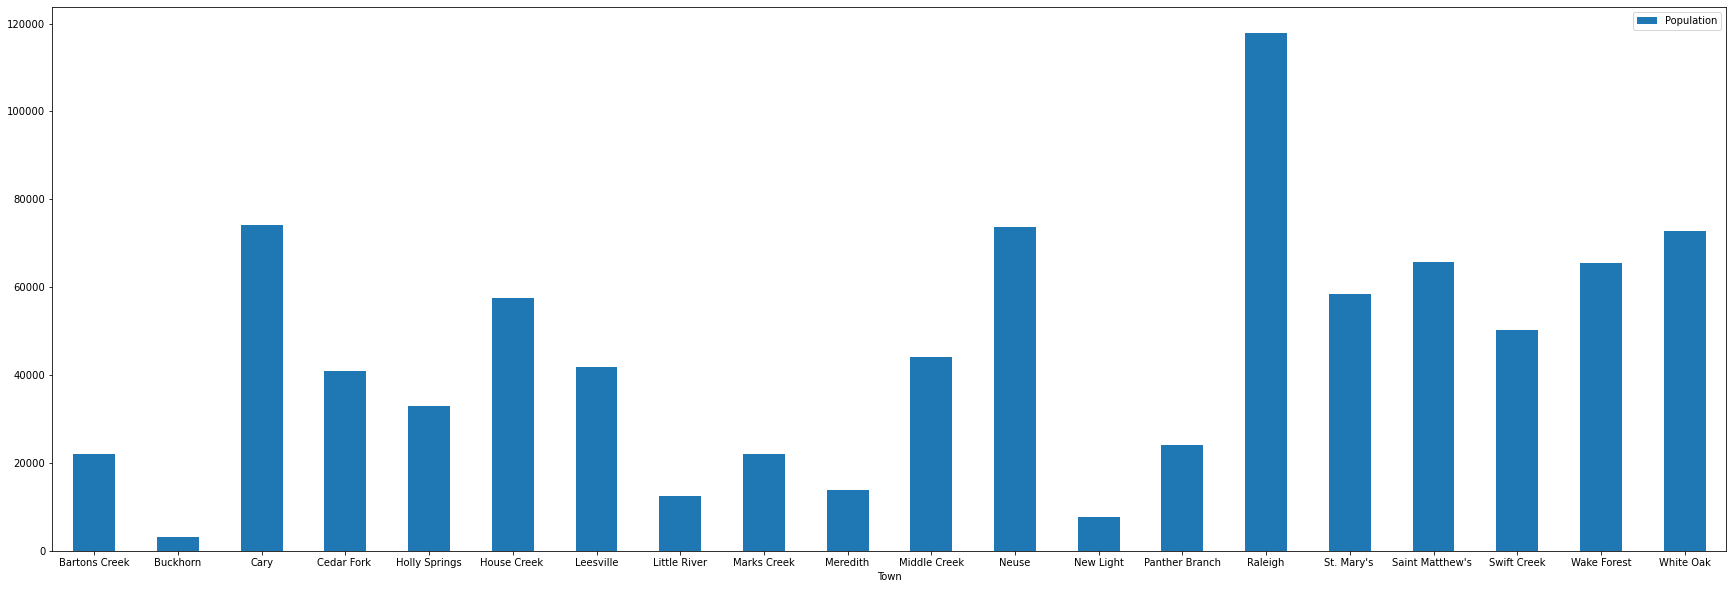

In [15]:
plt.rcParams['figure.figsize'] = [30, 10]
township_df.plot.bar(x='Town', y='Population', rot=0)

In [16]:
# data frame dimension
township_df.shape

(20, 4)

In [17]:
#Set the wake county latitude and longitude
wk_latitude= 35.79
wk_longituede = -78.65

In [18]:
# create to show all the towns
wake_map = folium.Map(location=[wk_latitude, wk_longituede], zoom_start=11)

# add town name and population markers to map
for lat, lng, town, population in zip(township_df['Latitude'], township_df['Longitude'], township_df['Town'], township_df['Population']):
    label = '{}, {}'.format(town, population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(wake_map)  
    
wake_map

In [19]:
#Setup Four Square API 

CLIENT_ID = 'OB2WMRYCS4NHK4CHKQLZ4XFSXKIJB5OOIFS4NUC2HQRV2UBT' # your Foursquare ID
CLIENT_SECRET = 'VRZH2JRWYUQ3V4WPGIHKX3J0FNTKXEF03HLGG4M4EHQ2FBRP' # your Foursquare Secret
VERSION = 20201010# Foursquare API version

print('Four Square Credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Four Square Credentials:
CLIENT_ID: OB2WMRYCS4NHK4CHKQLZ4XFSXKIJB5OOIFS4NUC2HQRV2UBT
CLIENT_SECRET:VRZH2JRWYUQ3V4WPGIHKX3J0FNTKXEF03HLGG4M4EHQ2FBRP


In [23]:
radius = 10000
LIMIT = 1000

venues = []
for lat, lng, town, population in zip(township_df['Latitude'], township_df['Longitude'], township_df['Town'], township_df['Population']):
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&time{},&day{}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius, 
        LIMIT,
        'any',
        'any')        
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']

    # filter only relevant information for each nearby venue
    for venue in results:
        venues.append((
            town,
            population,
            lat, 
            lng, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [24]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Town', 'Population', 'Latitude','Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head(10)

(1929, 8)


,Town,Population,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Bartons Creek,22055,35.950664,-78.645547,Homewood Nursery & Garden Center,35.927309,-78.621721,Hardware Store
1,Bartons Creek,22055,35.950664,-78.645547,Blue Jay Point County Park,35.969983,-78.640180,Park
2,Bartons Creek,22055,35.950664,-78.645547,A.E. Finley YMCA,35.907476,-78.657194,Gym
3,Bartons Creek,22055,35.950664,-78.645547,Sassool,35.903908,-78.656748,Mediterranean Restaurant
4,Bartons Creek,22055,35.950664,-78.645547,Goodberry's Frozen Custard,35.902244,-78.656899,Ice Cream Shop
5,Bartons Creek,22055,35.950664,-78.645547,Great Harvest Bread Company,35.905211,-78.656980,Bakery
6,Bartons Creek,22055,35.950664,-78.645547,Taylor's Wine Shop,35.915844,-78.650133,Wine Shop
7,Bartons Creek,22055,35.950664,-78.645547,Whole Foods Market,35.899209,-78.650282,Grocery Store
8,Bartons Creek,22055,35.950664,-78.645547,Poppyseed Market Café & Wine Bar,35.905084,-78.657466,Café
9,Bartons Creek,22055,35.950664,-78.645547,Char-Grill,35.901271,-78.655816,Burger Joint


In [25]:
#Extract the records if venu categroy is PET rleated
venues_df= venues_df.sort_values(by=['VenueCategory'])
pet_df = venues_df.loc[venues_df['VenueCategory'].str.contains('Pet|Animal|Vet|Department|Mall') == True] 
pet_df.shape
#pet_df

(50, 8)

In [26]:
#Sort
pet_df= pet_df.sort_values(by=['VenueCategory'])


In [27]:

# Convert categorical variable into dummy(indicator) variables.
pet_dummy = pd.get_dummies(pet_df['VenueCategory'],prefix='',prefix_sep='')

In [28]:
pet_dummy

,Department Store,Pet Service,Pet Store,Shopping Mall,Veterinarian
1107,1,0,0,0,0
70,1,0,0,0,0
1071,1,0,0,0,0
1035,1,0,0,0,0
1454,1,0,0,0,0
1165,1,0,0,0,0
690,1,0,0,0,0
1441,1,0,0,0,0
1811,1,0,0,0,0
722,1,0,0,0,0


In [29]:

# Merging the dummy variables with the original dataframe
pet_mergeted_df = pd.merge(pet_df,pet_dummy,on=pet_df.index)
pet_mergeted_df

,key_0,Town,Population,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory,Department Store,Pet Service,Pet Store,Shopping Mall,Veterinarian
0,1107,Neuse,73617,35.869952,-78.588795,Kohl's,35.905490,-78.602343,Department Store,1,0,0,0,0
1,70,Bartons Creek,22055,35.950664,-78.645547,Kohl's,35.905490,-78.602343,Department Store,1,0,0,0,0
2,1071,Neuse,73617,35.869952,-78.588795,T.J. Maxx,35.874034,-78.624915,Department Store,1,0,0,0,0
3,1035,Neuse,73617,35.869952,-78.588795,Dillard's,35.865909,-78.577609,Department Store,1,0,0,0,0
4,1454,St. Mary's,58484,35.697611,-78.588795,Kohl's,35.693394,-78.580289,Department Store,1,0,0,0,0
5,1165,New Light,7591,36.012532,-78.597331,Kohl's,35.987050,-78.530997,Department Store,1,0,0,0,0
6,690,Little River,12528,35.843485,-78.315941,Belk,35.832183,-78.316864,Department Store,1,0,0,0,0
7,1441,St. Mary's,58484,35.697611,-78.588795,T.J. Maxx,35.691562,-78.581783,Department Store,1,0,0,0,0
8,1811,Wake Forest,65491,35.947230,-78.497925,Kohl's,35.987050,-78.530997,Department Store,1,0,0,0,0
9,722,Little River,12528,35.843485,-78.315941,Kannon's Of Wendell,35.781359,-78.369921,Department Store,1,0,0,0,0


In [30]:
pet_mergeted_df.drop(['key_0'],axis=1,inplace=True)


In [31]:
pet_group_cluster = pet_mergeted_df.drop(['Town','Population','Latitude','Longitude','VenueName','VenueLatitude','VenueLongitude','VenueCategory'],axis=1)

In [32]:
pet_group_cluster.head()

,Department Store,Pet Service,Pet Store,Shopping Mall,Veterinarian
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


## 4.0 Modeling 

### Using KMeans Machine Learning Algorithm for the clustering of the Pet services and stores  near the townships.

In [33]:
k=5
kmeans = KMeans(n_clusters=k,random_state=0).fit(pet_group_cluster)
kmeans.labels_[0:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [34]:
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 3, 3], dtype=int32)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)


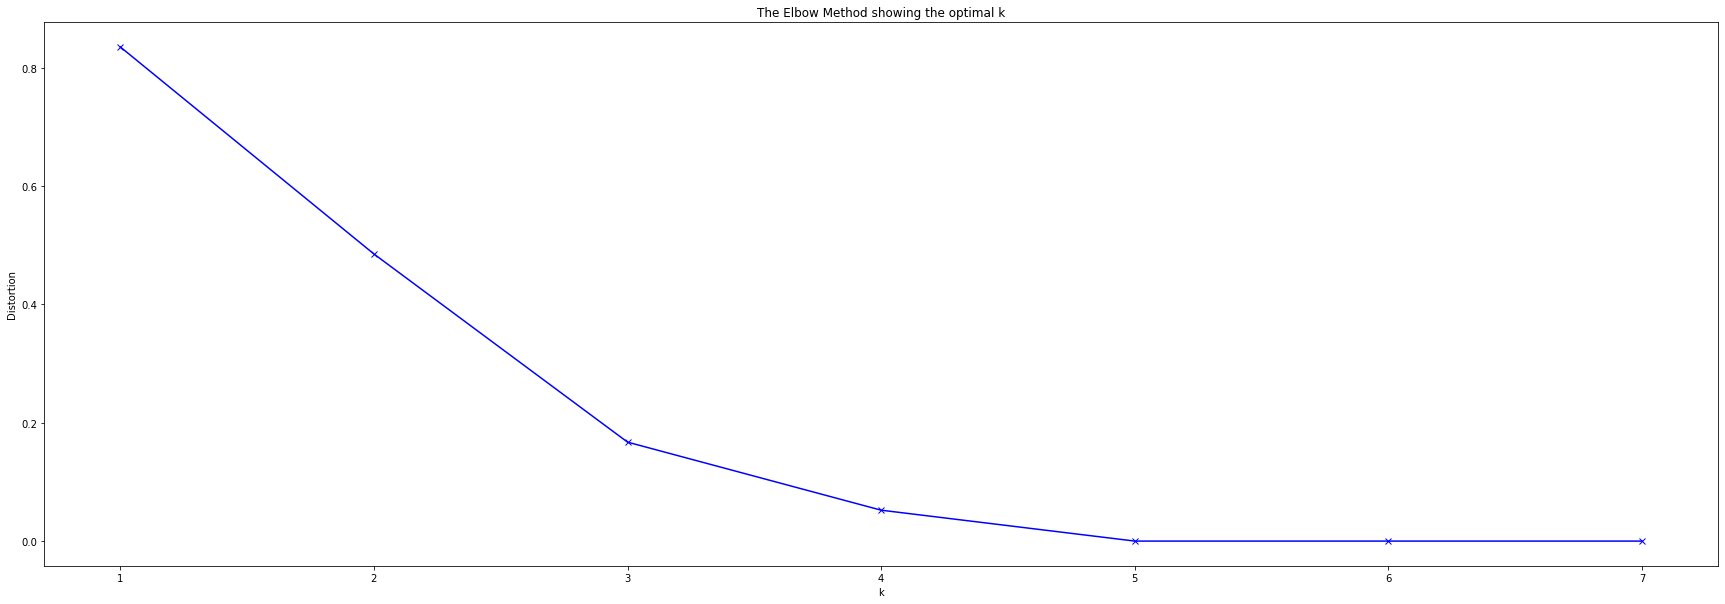

In [35]:

# k means determine k
distortions = []
K = range(1,8)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(pet_group_cluster)
    kmeanModel.fit(pet_group_cluster)
    distortions.append(sum(np.min(cdist(pet_group_cluster, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / pet_group_cluster.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [36]:
pet_mergeted_df.insert(0,'ClusterLabels',kmeans.labels_)

#### Creating the map of all the Pet store and pet services  and plotting all the companies on the same map for evaluation purpose. The clusters in the map shows different types of Pet stores

In [37]:
# create map

map_clusters =  folium.Map(location=[wk_latitude, wk_longituede], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, name, cat, cluster in zip(pet_mergeted_df['VenueLatitude'], pet_mergeted_df['VenueLongitude'], pet_mergeted_df['VenueName'],pet_mergeted_df['VenueCategory'], pet_mergeted_df['ClusterLabels']):
    label = folium.Popup(name +','+ cat + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
for lat, lng, population, neighbourhood in zip(township_df['Latitude'], township_df['Longitude'], township_df['Population'], township_df['Town']):
    label = '{}, {}'.format(population, neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters) 

map_clusters

Analysing the clustres

In [40]:
cluster0 = pet_mergeted_df.loc[pet_mergeted_df['ClusterLabels'] == 0, pet_mergeted_df.columns[[1] + list(range(5, pet_mergeted_df.shape[1]))]]


In [41]:
cluster0['VenueCategory'].value_counts()

Shopping Mall    12
Name: VenueCategory, dtype: int64

#### The Cluster 0 is shown in Red Colour and contains the most number of Shipping Mall

In [42]:
cluster1 = pet_mergeted_df.loc[pet_mergeted_df['ClusterLabels'] == 1, pet_mergeted_df.columns[[1] + list(range(5, pet_mergeted_df.shape[1]))]]

In [43]:
cluster1['VenueCategory'].value_counts()

Pet Store    16
Name: VenueCategory, dtype: int64

#### The Cluster 1 is shown in Purple Colour and contains the most number of Pet stores


In [44]:
cluster2 = pet_mergeted_df.loc[pet_mergeted_df['ClusterLabels'] == 2, pet_mergeted_df.columns[[1] + list(range(5, pet_mergeted_df.shape[1]))]]

In [45]:
cluster2['VenueCategory'].value_counts()

Department Store    18
Name: VenueCategory, dtype: int64

#### The Cluster 2 is shown in blue Colour and contains the most number of Department stores

In [46]:
cluster3 = pet_mergeted_df.loc[pet_mergeted_df['ClusterLabels'] ==3, pet_mergeted_df.columns[[1] + list(range(5, pet_mergeted_df.shape[1]))]]

In [47]:
cluster3['VenueCategory'].value_counts()

Veterinarian    3
Name: VenueCategory, dtype: int64

#### The Cluster 3 is shown in light green Colour and contains the most number of Vet hopitals


# Observations
1. Max no to stores in the cluster is Department store
2. Small towns Panther Branch, buckhon, swift creek, New light , Barton creek dont have any services
3. Cary one of the hightest population does not have any service 
3. Raleigh one of the hightest population does not have any service 
4. Cary shopping mall is an option